#### Directories etc

In [2]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from Bio import Entrez, SeqIO, AlignIO, pairwise2, Align, Seq, motifs
from Bio.Seq import Seq
from Bio.SeqFeature import SeqFeature, FeatureLocation
from scipy.stats import binom
import math
import random
from tqdm import tqdm
from Comparative_Analysis import Utilities as util
import random
from joblib import Parallel, delayed
from Comparative_Analysis import Blast_Functions as blastfn
import time
import os
import copy
from scipy.stats import chi2, chi2_contingency
from Comparative_Analysis import ORF_Functions as orffn
from Comparative_Analysis import Alignment as alignfn
from random import sample
from Bio.Align.Applications import MuscleCommandline
import subprocess
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
project_dir = 'F:/Project_Data/Intergenic_Region_Comparative_Analysis'
seq_dir_1 = 'F:/Datasets/NCBI_Refseq_Mycobacteriaceae_All_Levels/ncbi_dataset/data'
seq_dir_2 = 'F:/Datasets/NCBI_Refseq_Actinobacteria_All_Levels/data'
sequence_dirs_1 = util.list_dirs(seq_dir_1)
sequence_dirs_2 = util.list_dirs(seq_dir_2)
tb_species = 'NC_000962.3' 
tb_annotation_dirname = 'GCF_000195955.2'
num_cores = 16
core_numbers = list(range(1, num_cores+1))
muscle_exe = 'C:/Users/nicho/Muscle/muscle3.8.31_i86win32.exe'
full_build = False

In [4]:
cortes_dict = {}
utr_category_dict = {}
cortes_df = pd.read_csv('F:/Datasets/Data_From_Publications/Cortes_TSS.csv')
for i, r in cortes_df.iterrows():
    cortes_dict[r['RvNumber']] = r['Leaderless']
    utr_category_dict[r['RvNumber']] = r['UTR Category']

In [5]:
cds_info_dict = {}
for genome_record in SeqIO.parse(seq_dir_1 + '/' + tb_annotation_dirname + '/genomic.gbff', "genbank"):
    for feature in genome_record.features:
        a = feature.qualifiers
        if feature.type == 'CDS' and a.get("translation") != None:
            locus_tag = a.get("locus_tag")[0]
            product = a.get("product")[0]
            cds_info_dict[locus_tag] = product  

In [6]:
cortes_df

,RvNumber,Synonym,Strand,UTR Category,Leaderless,Operon Category,Exponential RPKM
0,Rv0001,dnaA,+,SD,NaN,NaN,34.29
1,Rv0002,dnaN,+,U,NaN,NaN,24.17
2,Rv0003,recF,+,U,NaN,NaN,9.83
3,Rv0004,Rv0004,+,NaN,NaN,NaN,4.89
4,Rv0005,gyrB,+,U,NaN,NaN,85.84
...,...,...,...,...,...,...,...
4017,Rv3920c,Rv3920c,-,NaN,NaN,U,16.29
4018,Rv3921c,Rv3921c,-,U,NaN,NaN,29.16
4019,Rv3922c,Rv3922c,-,NaN,NaN,U,41.00
4020,Rv3923c,rnpA,-,U,NaN,NaN,54.02


In [ ]:
seq_ids = util.list_dirs(project_dir)
seq_ids.sort()
out_list = []
all_pairs = []
pair_utr_count = 0
pair_other_count = 0
non_pair_utr_count = 0
non_pair_other_count = 0
for id in (seq_ids):
    consensus = []
    if os.path.exists(project_dir + '/' + str(id) + '/upstream_region_no_insertions'+str(id) + '_alignment_2.sto') and not(os.path.exists(project_dir + '/' + str(id) + '/rscape_output_no_insertions2.cov')):
        print(id)
        #blastfn.run_rscape(project_dir + '/' + str(id), 'upstream_region_no_insertions'+str(id) + '_alignment_2.sto', 'rscape_output_no_insertions2')


In [8]:
distance = 100000
seq_ids = util.list_dirs(project_dir)
seq_ids.sort()
out_list = []
all_pairs = []
data = []
pair_utr_count = 0
pair_other_count = 0
non_pair_utr_count = 0
non_pair_other_count = 0
for id in (seq_ids):
    consensus = []
    if os.path.exists(project_dir + '/' + str(id) + '/upstream_region_no_insertions'+str(id) + '_alignment_2.fasta'):
        alignment = util.read_fasta_to_array(project_dir + '/' + str(id) + '/upstream_region_no_insertions'+str(id) + '_alignment_2.fasta')
        num_sequences = len(alignment[0])
        num_characters = len(alignment[1][0])
        for i in range(num_characters):
            temp = []
            for j in range(num_sequences):
                temp.append(alignment[1][j][i])
            consensus_found = False
            for letter in ['A','C','G','T']:
                if temp.count(letter) / num_sequences > 0.5:
                    consensus.append(letter)
                    consensus_found = True
            if consensus_found == False:
                consensus.append('-')
        if os.path.exists(project_dir + '/' + str(id) + '/rscape_output_no_insertions2.cov'):
            with open(project_dir + '/'+str(id) +  '/rscape_output_no_insertions2.cov', 'r') as f:  
                num_pairs = 0
                e_values = []
                pairs = []
                for l in f:
                    if (not ('#' in l)):
                        a = l.split()
                        if len(a) > 6: 
                            if num_characters - int(a[1]) <= distance:
                                pairs.append(int(a[1]))
                            if num_characters - int(a[2]) <= distance:
                                pairs.append(int(a[2]))
            pairs = (set(pairs))
            if len(pairs) > 0:
                for i in pairs:
                    if consensus[i-1] == '-':
                        consensus[i-1] = 'x'
                    else:
                        consensus[i-1] = consensus[i-1].lower()
            
            if id in cortes_dict:
                if cortes_dict[id] == 'L':
                    leaderless = 'Y'
                else:
                    leaderless = 'N'
            else:
                leaderless = 'N'
            if id in utr_category_dict:
                utr_category = utr_category_dict[id]
            else:
                utr_category = ''
            #print(id, len(pairs), leaderless, utr_category, cds_info_dict[id],''.join(consensus)[-1*distance:])
            if len(pairs)> 0:
                pairs_ind = 1
            else:
                pairs_ind = 0
            if utr_category in ['SD']:
                utr_ind = 1
            else:
                utr_ind = 0
            data.append([pairs_ind, utr_ind])
output_df = pd.DataFrame(data, columns = ['pairs', 'utr'])
            #if len(pairs) > 0:
            #    if utr_category in ['SD']:
            #        pair_utr_count +=1
            #    else:
            #        pair_other_count +=1
            #else:        
            #    if utr_category in ['SD']:
            #        non_pair_utr_count +=1
            #    else:
            #        non_pair_other_count +=1


#print(pair_utr_count, pair_other_count, non_pair_utr_count, non_pair_other_count)

In [9]:
contigency= pd.crosstab(output_df['pairs'], output_df['utr']) 
# Chi-square test of independence. 
c, p, dof, expected = chi2_contingency(contigency) 
print(contigency)
# Print the p-value
print(p)

utr      0    1
pairs          
0      981  214
1      397  145
3.267196856916555e-05


#### Extract covariation information to identify potentially significant regions

Rv0002 7 1.5913936834976994e-12 530 [10, 11, 226, 227, 230, 231, 232, 243, 244, 245, 246, 377, 379]
Rv0005 8 6.922318274149575e-11 245 [4, 6, 7, 8, 9, 10, 11, 14, 16, 110, 115, 121, 129]
Rv2614c 21 0.0 111 [2, 3, 8, 9, 10, 11, 12, 13, 14, 28, 30, 45, 46, 47, 48, 49, 51, 52, 53]
Rv0011c 1 2.7490399999718917e-06 96 [12, 13]
Rv0020c 59 0.0 471 [188, 189, 203, 206, 207, 229, 230, 232, 240, 242, 243, 248, 250, 251, 252, 253, 261, 270, 275, 277, 278, 279, 281, 282]
Rv2637 17 0.0 198 [2, 3, 7, 8, 9, 10, 12, 14, 18, 19]
Rv0041 39 0.0 199 [2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 39, 40, 129, 130]
Rv0053 21 0.0 221 [2, 4, 5, 6, 7, 10, 12, 13, 22, 23, 26, 28, 29, 30, 36, 37, 38, 39, 41, 42, 43, 49, 50, 51, 52, 61, 92, 94]
Rv2674 1 2.2266800000503295e-06 116 [9, 13]
Rv2682c 12 0.0 146 [1, 3, 4, 7, 8, 9, 13, 14, 15, 16, 18]
Rv2690c 11 0.0 137 [3, 4, 8, 9, 10, 12, 13, 14, 17, 19, 21, 22]
Rv2699c 8 2.767047813101442e-09 240 [5, 6, 10, 11, 13, 47, 48, 72, 73, 97, 98, 102, 108]
Rv2

Text(0.5, 0, 'Relative position upstream of 3rd nucleotide in start codon')

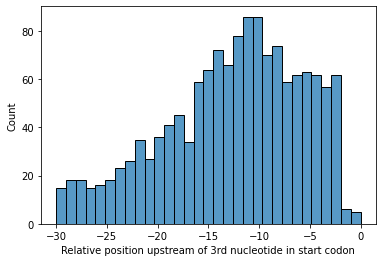

In [11]:
seq_ids = util.list_dirs(project_dir)
out_list = []
all_pairs = []
for id in seq_ids:
    if os.path.exists(project_dir + '/' + str(id) + '/rscape_output_no_insertions2.cov'):
        alignment = util.read_fasta_to_array(project_dir + '/' + str(id) + '/upstream_region_no_insertions'+str(id) + '_alignment_2.fasta')
        seq_len = len(alignment[1][0])
        with open(project_dir + '/'+str(id) +  '/rscape_output_no_insertions2.cov', 'r') as f:  
            num_pairs = 0
            e_values = []
            pairs = []
            for l in f:
                if (not ('#' in l)):
                    a = l.split()
                    if len(a) > 6: # and abs(int(a[2])-int(a[1])) > 3:    # Exclude covarying pairs less than 3 bp apart)
                        #if seq_len - int(a[1]) < 30 and seq_len - int(a[1]) < 30:
                        pairs.append(seq_len - int(a[1]))
                        pairs.append(seq_len - int(a[2]))
                        e_values.append(float(a[4]))
                        num_pairs +=1
        if len(e_values) > 0:
            tot = sum([math.log(x) for x  in e_values])
            num = len(e_values)
            combined_e_value = 1-chi2.cdf(-2*tot, 2*num)
        else:
            combined_e_value = 999
        if combined_e_value < 1e-5:
            print(id, num_pairs, combined_e_value, seq_len, sorted(set(pairs)))
            for i in set(pairs):
                all_pairs.append(i*-1)
sns.histplot([x for x in all_pairs if x >= -30], bins =31)
plt.xlabel('Relative position upstream of 3rd nucleotide in start codon')

In [203]:
sequence_dirs_1 = util.list_dirs(seq_dir_1)

In [240]:
temp = []
for seq_dir in sequence_dirs_1:
    if os.path.exists(seq_dir_1 + '/' + seq_dir + '/genomic.gbff'):
        for genome_record in (SeqIO.parse(seq_dir_1 + '/' + seq_dir + '/genomic.gbff', "genbank")):
            organism = genome_record.annotations['organism']
            full_sequence = str(genome_record.seq)
            for feature in genome_record.features:
                    a = feature.qualifiers
                    if feature.type == 'rRNA' and '16S' in a.get("product")[0]:
                        (start, stop, strand) = (int(feature.location.start), int(feature.location.end), int(feature.location.strand))
                        if (strand == 1 and not(full_sequence[stop-9:stop] == 'ACCTCCTTT')) or (strand == -1 and not (util.reverse_complement(full_sequence[start:start+9]) == 'ACCTCCTTT')):


                            if strand == 1:
                                temp.append([organism, (start, stop, strand),  a.get("product")[0], full_sequence[stop-20:stop]])
                            else:
                                temp.append([organism, (start, stop, strand),  a.get("product")[0], util.reverse_complement(full_sequence[start:start+20])])
temp_df = pd.DataFrame(temp, columns = ['species','location', 'product', 'sequence'])
temp_df.to_csv(project_dir +'/non_standard_ASD.csv')

In [193]:
sequence_dirs_2 = util.list_dirs(seq_dir_2)

In [5]:
len(sequence_dirs_2)

1757

In [4]:
len(sequence_dirs_1)

215

####  See if 16S shows covariation

In [6]:
count = 0
for seq_dir in sequence_dirs_2:
    if os.path.exists(seq_dir_2 + '/' + seq_dir + '/genomic.gbff'):
        count +=1
print(count)

1748


In [222]:
temp = []
for seq_dir in tqdm(sequence_dirs_2):
    if os.path.exists(seq_dir_2 + '/' + seq_dir + '/genomic.gbff'):
        for genome_record in (SeqIO.parse(seq_dir_2 + '/' + seq_dir + '/genomic.gbff', "genbank")):
            organism = genome_record.annotations['organism']
            full_sequence = str(genome_record.seq)
            for feature in genome_record.features:
                a = feature.qualifiers
                if feature.type == 'rRNA' and '16S' in a.get("product")[0]:
                    (start, stop, strand) = (int(feature.location.start), int(feature.location.end), int(feature.location.strand))
                    if strand == 1:
                        temp.append([organism,  full_sequence[stop-20:stop]])
                       
                    else:
                        temp.append([organism,  util.reverse_complement(full_sequence[start:start+20])])
                    break

util.produce_fasta_file(temp, project_dir +'/30S.fasta')

100%|██████████| 2560/2560 [00:00<00:00, 73138.19it/s]


In [237]:
names = []
temp_2 = []
for x in temp:
    name =  x[0].replace(' ','_')[0:50]
    if name in names:
        continue
    else:
        temp_2.append([name, x[1]])
        names.append(name)
util.produce_fasta_file(temp_2, project_dir +'/30S.fasta')

100%|██████████| 1727/1727 [00:00<00:00, 246648.15it/s]


In [239]:
cline = MuscleCommandline(muscle_exe, input = project_dir +'/30S.fasta', out = project_dir +'/30S_alignment.fasta')
cline()
blastfn.convert_fasta_to_stockholm(project_dir, '30S.fasta', '30S.sto')
blastfn.run_rscape(project_dir, '30S.sto', 'rscape_output_30S')

In [235]:
util.convert_sequence_file_format(project_dir + '/30S_alignment.fasta', project_dir + '/30S_alignment.sto')

In [236]:
blastfn.run_rscape(project_dir, '30S_alignment.sto', 'rscape_output_30S')

#####  Find potential structural regions

In [13]:
seq_ids = util.list_dirs(project_dir)
for id in seq_ids:
    if os.path.exists(project_dir + '/' + str(id) + '/rscape_output_2.cov'):
        alignment = util.read_fasta_to_array(project_dir + '/' + str(id) + '/upstream_region_'+str(id) + '_alignment_2.fasta')
        num_sequences = len(alignment[0])
        num_characters = len(alignment[1][0])
  
        with open(project_dir + '/'+str(id) +  '/rscape_output_2.cov', 'r') as f:  
            num_pairs = 0
            e_values = []

            for l in f:
                if (not ('#' in l)):
                    a = l.split()
                    if len(a) > 6 and abs(int(a[2])-int(a[1])) > 8 and abs(int(a[1])-num_characters) > 10 and abs(int(a[2])-num_characters) > 10:    # Exclude covarying pairs less than 3 bp apart)
                        e_values.append(float(a[4]))
                        num_pairs+=1
        if len(e_values) > 0:
            tot = sum([math.log(x) for x  in e_values])
            num = len(e_values)
            combined_e_value = 1-chi2.cdf(-2*tot, 2*num)
        else:
            combined_e_value = 999
        if combined_e_value < 1e-5:
            print(id, num_pairs, combined_e_value)


Rv2614c 9 8.884004643050503e-13
Rv0020c 48 0.0
Rv2637 7 3.885780586188048e-15
Rv0053 10 0.0
Rv2682c 1 8.711819999951409e-06
Rv2690c 7 3.3306690738754696e-16
Rv2737c 5 2.130664400468163e-08
Rv2783c 21 0.0
Rv2785c 20 0.0
Rv2845c 6 1.3705703238997557e-12
Rv2847c 4 2.920774733183862e-12
Rv2867c 3 0.0
Rv0129c 5 2.6739788161478373e-10
Rv2883c 2 8.74210494550276e-07
Rv2890c 17 0.0
Rv0189c 5 2.3841081870923375e-06
Rv2904c 5 9.096801611985228e-08
Rv0211 3 4.955414313334572e-06
Rv1388 5 2.680799160437175e-08
Rv2909c 3 7.623563992198434e-06
Rv1392 3 1.326234377874158e-07
Rv2921c 2 7.124945078373912e-11
Rv1436 3 3.35143024443596e-12
Rv0237 4 4.353897152808983e-07
Rv0244c 30 0.0
Rv1449c 63 0.0
Rv2975a 5 9.68625180064464e-12
Rv2981c 7 0.0
Rv2986c 5 3.000126569396855e-07
Rv1479 3 8.386324098497155e-07
Rv0357c 3 2.5159430094845447e-11
Rv3003c 41 0.0
Rv1536 8 0.0
Rv3025c 17 0.0
Rv3027c 2 5.569872751909344e-08
Rv0423c 5 0.0
Rv0425c 1 3.4252199999640354e-06
Rv1609 2 5.8914318978864344e-08
Rv3050c 4 3.803